In [1]:
import chemistry_vae_selfies
import data_loader
import selfies
import torch
import importlib
import yaml
import pandas as pd
import numpy as np
import torch.distributions as dist
import matplotlib.pyplot as plt
import networkx as nx
from pysmiles import read_smiles

In [2]:
# here we want to read in data and tranform them into one_hot
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder_path = "./datasets/"
file_name = "SelectedSMILES_QM9.txt"

full_path = folder_path + file_name

selfies_list, selfies_alphabet, largest_selfies_len, smiles_list, smiles_alphabet, largest_smiles_len = chemistry_vae_selfies.get_selfie_and_smiles_encodings_for_dataset(full_path)

--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.
selfies aplhabet: ['[nop]', '[=Branch1]', '[O]', '[C]', '[Branch2]', '[F]', '[=O]', '[Ring1]', '[Ring2]', '[N]', '[#N]', '[=N]', '[=Branch2]', '[#Branch2]', '[#Branch1]', '[Branch1]', '[#C]', '[=C]']
smiles aplhabet: ['4', '#', '3', 'C', ')', '2', '(', 'F', 'N', '1', 'O', '=', '5', ' ']


In [3]:
# define source file location
file_to_load =  "./saved_models_RNN/"
#file_to_load =  "./model runs/saved_models_run1/"
#file_to_load =  "./saved_models_run1/"
# training file name encoder
training_file_nameE = "300/E"
# training file name decoder
training_file_nameD = "300/D"
# load data
#load_data_trained = file_to_load + training_file_nameE
# Alphabet has 18 letters, largest molecule is 21 letters. (build this as an output function later ... )
largest_selfies_len_dataset = largest_selfies_len
largest_smiles_len_dataset = largest_smiles_len

#in_dimension = len(selfies_alphabet)*largest_selfies_len
in_dimension = len(smiles_alphabet)*largest_smiles_len



# load the trained encoder
vae_encoder = torch.load(file_to_load + training_file_nameE) #, map_location=torch.device(device="cpu"))
#print(vae_encoder)

# load the trained decoder
vae_decoder = torch.load(file_to_load + training_file_nameD) #, map_location=torch.device(device="cpu"))
#print(vae_decoder)

In [4]:
selfies_alphabet = ['[#Branch2]', '[Ring2]', '[Branch2]', '[=Branch2]', '[O]', '[=O]', '[=C]', '[=N]', '[#Branch1]', '[=Branch1]', '[nop]', '[N]', '[Branch1]', '[F]', '[#C]', '[#N]', '[Ring1]', '[C]']


In [5]:
# useful functions

def translate_selfie(sequence):  


        for i in range(len(sequence)):
                SELFIESGenerated = SELFIESGenerated + selfies_alphabet[sequence[i]]
        return SELFIESGenerated

def translate_smile(sequence):  

        SELFIESGenerated = ""

        for i in range(len(sequence)):
                SELFIESGenerated = SELFIESGenerated + smiles_alphabet[sequence[i]]
        return SELFIESGenerated
        
def create_onehot_instance(selfie_input,largest_selfies_len,selfies_alphabet_in):

    inttest_hot, arraytest_hot = data_loader.selfies_to_hot(selfie_input,largest_selfies_len, selfies_alphabet_in)
    x = torch.from_numpy(arraytest_hot).flatten().float().unsqueeze(0)
    return x

def create_onehot_instance_smiles(smile_input,largest_smiles_len,smiles_alphabet_in):

    inttest_hot, arraytest_hot = data_loader.smile_to_hot(smile_input,largest_smiles_len, smiles_alphabet_in)
    x = torch.from_numpy(arraytest_hot).flatten().float().unsqueeze(0)
    return x

def create_latent_space_vector(selfie_input,largest_selfies_len,selfies_alphabet_in):

    x = create_onehot_instance(selfie_input,largest_selfies_len,selfies_alphabet_in)

    z =set()
    vae_encoder.eval()
    vae_decoder.eval()
    z, mu, log_var = vae_encoder(x)

    return z.unsqueeze(0)

def create_latent_space_vector_smiles(smile_input,largest_smiles_len,smiles_alphabet_in):

    x = create_onehot_instance_smiles(smile_input,largest_smiles_len,smiles_alphabet_in)

    z =set()
    vae_encoder.eval()
    vae_decoder.eval()
    z, mu, log_var = vae_encoder(x)

    return z.unsqueeze(0)

def create_random_latent_space_vector(largest_selfies_len,selfies_alphabet_in):

    # Random input tensor for tests
    in_dimension_input = largest_selfies_len*len(selfies_alphabet_in)
    x = torch.randn(in_dimension_input).unsqueeze(0)

    z =set()
    vae_encoder.eval()
    vae_decoder.eval()
    z, mu, log_var = vae_encoder(x)

    return z.unsqueeze(0)


def decode_from_latentspace(latent_point_in, largest_selfies_len_in, selfies_alphabet_len, method):

        #one_hot_dimension = torch.zeros(selfies_alphabet_len,largest_selfies_len_in)
        #out_one_hot = torch.zeros_like(one_hot_dimension, device=device)

        vae_decoder.eval()
        vae_encoder.eval()

        sequence = []

        hidden = vae_decoder.init_hidden(batch_size=1)

         
        for seq_index in range(largest_selfies_len_in):
                out_one_hot_line, hidden = vae_decoder(latent_point_in, hidden)

                if method == 0:
                        sequence.append(out_one_hot_line.argmax())

                elif method ==1:
                        # Apply softmax and sample from the distribution to get the next token
                        softmax = torch.nn.Softmax(dim=2)
                        probabilities = softmax(out_one_hot_line)
                        categorical_dist = dist.Categorical(probabilities)
                        sample = categorical_dist.sample()
                        sequence.append(sample)

                else:
                        print("method is 0 for argmax or 1 for stat sampling")
        
        

        return sequence

In [6]:
# pick a molecule

selfie_input = selfies_list[23430]
print(selfie_input)
print(selfies.decoder(selfie_input))

[C][C][=N][C][=C][N][=C][Ring1][=Branch1][F]
CC1=NC=CN=C1F


In [7]:
print("encoded in", selfies.decoder(selfie_input))

for i in range(1):
    coded_selfie_from_latent_space = decode_from_latentspace(create_latent_space_vector(selfie_input,largest_selfies_len,selfies_alphabet) , largest_selfies_len, len(selfies_alphabet),0) 
    selfie_from_latent_space = translate_selfie(coded_selfie_from_latent_space)
    print("reconstructed out", selfies.decoder(selfie_from_latent_space))

encoded in CC1=NC=CN=C1F
reconstructed out CC1=CC=CC=C1F


In [8]:
print("encoded in", selfies.decoder(selfie_input))

for i in range(10):
    coded_selfie_from_latent_space = decode_from_latentspace(create_latent_space_vector(selfie_input,largest_selfies_len,selfies_alphabet) , largest_selfies_len, len(selfies_alphabet),1) 
    selfie_from_latent_space = translate_selfie(coded_selfie_from_latent_space)
    print("reconstructed out", selfies.decoder(selfie_from_latent_space))

encoded in CC1=NC=CN=C1F
reconstructed out FC1=CC=CN=C1F
reconstructed out CC1=CC=NC=C1F
reconstructed out CC1=NN=CC=N1
reconstructed out FC1=NC=NC=C1F
reconstructed out CC1=CN=CC=C1F
reconstructed out CC1NN=NC=N1
reconstructed out CC1=CC=NC=N1
reconstructed out CC1=CC=NC=C1F
reconstructed out CC1NN=NC=N1
reconstructed out CC1=CC=CN=N1


OC1CN=CNC1=N


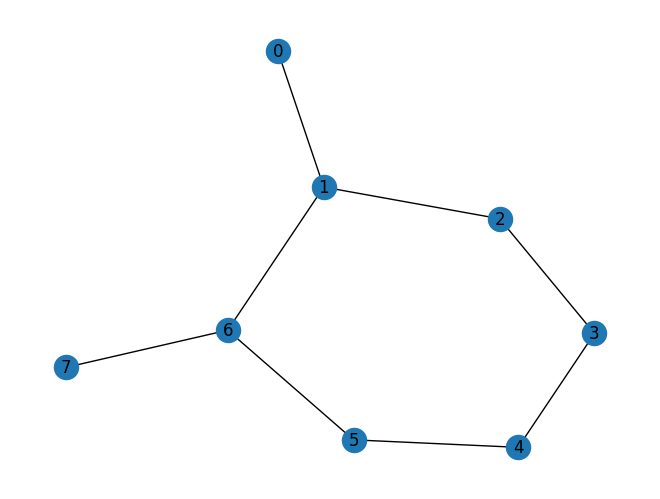

In [9]:
# Read the SMILES string

selfie_input = selfies_list[12174]

mol = read_smiles(selfies.decoder(selfie_input))

# Create a drawing of the molecule
pos = nx.spring_layout(mol)
nx.draw(mol, pos, with_labels=True)

# Display the drawing
print(selfies.decoder(selfie_input))
plt.show()


input molecule OC1CN=CNC1=N


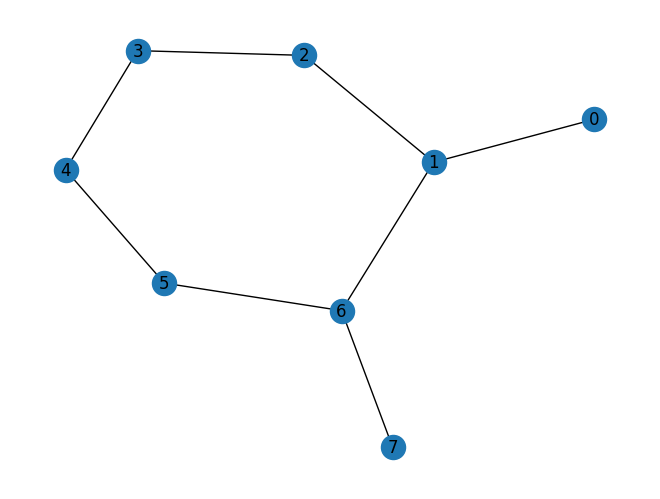




reconstructed molecule: OC1=CN=CNC1=N


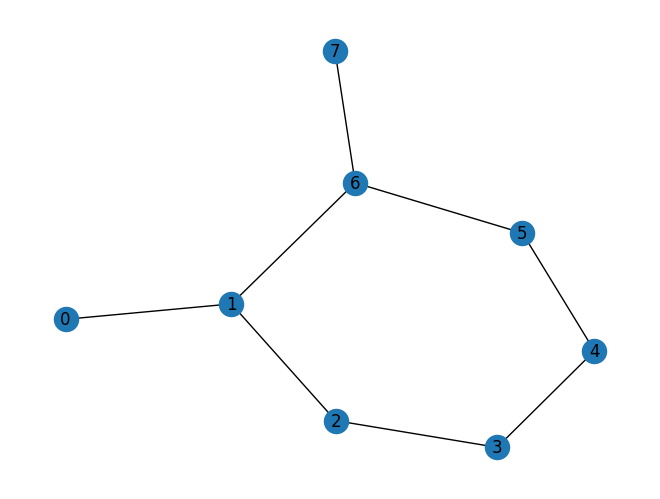

In [10]:
# number of drwas
trial_runs = 1

# Read the SMILES string
mol = read_smiles(selfies.decoder(selfie_input))

# Create a drawing of the molecule
pos = nx.spring_layout(mol)
nx.draw(mol, pos, with_labels=True)

# Display the drawing
print("input molecule",selfies.decoder(selfie_input))
plt.show()
print("")
print("")
print("")

for i in range(trial_runs):
    coded_selfie_from_latent_space = decode_from_latentspace(create_latent_space_vector(selfie_input,largest_selfies_len,selfies_alphabet) , largest_selfies_len, len(selfies_alphabet),0) 
    selfie_from_latent_space = translate_selfie(coded_selfie_from_latent_space)
    #if len(selfies.decoder(selfie_from_latent_space)) > len( selfies.decoder(selfie_input)) - 1 and len(selfies.decoder(selfie_from_latent_space)) < len( selfies.decoder(selfie_input)) + 1:
        # Read the SMILES string
    mol = read_smiles( selfies.decoder(selfie_from_latent_space) )
        # Create a drawing of the molecule
    pos = nx.spring_layout(mol)
    nx.draw(mol, pos, with_labels=True)
        # Display the drawing
    print("reconstructed molecule:",  selfies.decoder(selfie_from_latent_space))
        
    plt.show()


input molecule OC1CN=CNC1=N


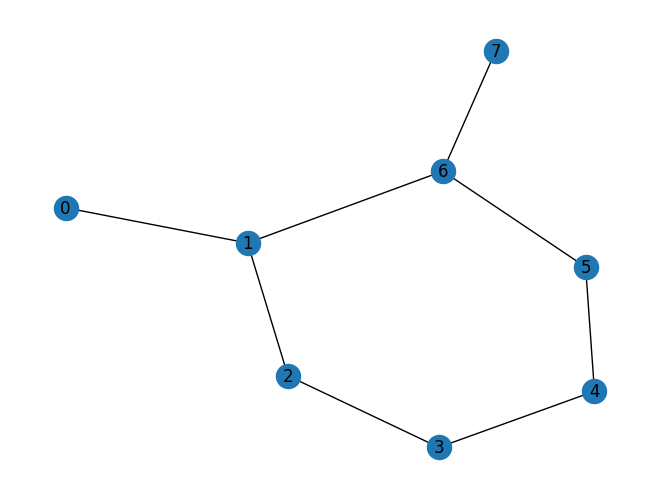




reconstructed molecule: OC1=CN=NOC1=N


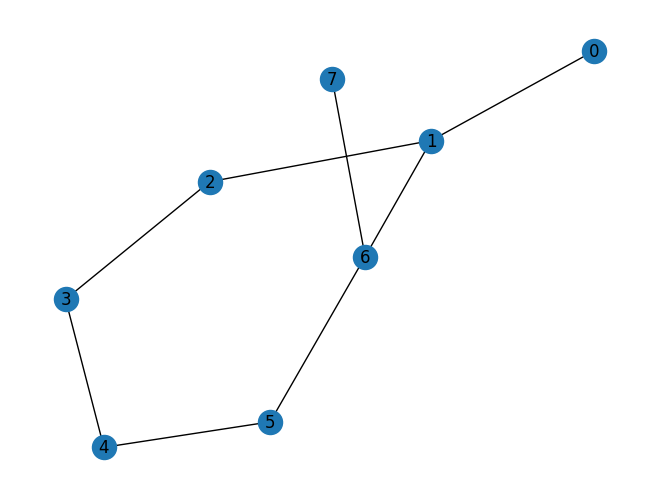

reconstructed molecule: OC1=CN=CNC1=O


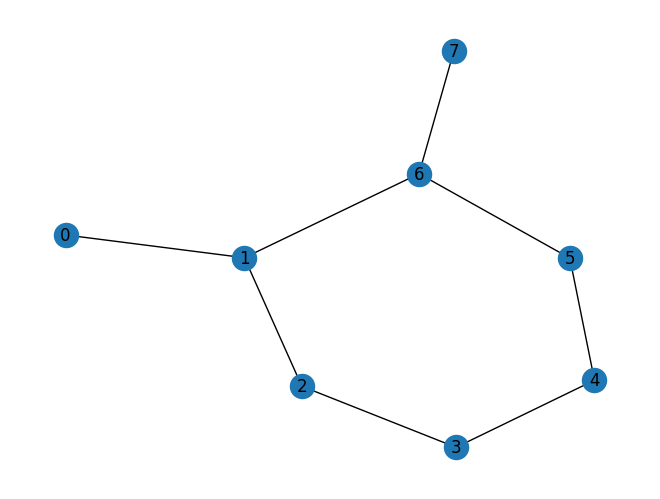

reconstructed molecule: OC1=CC=CNC1=O


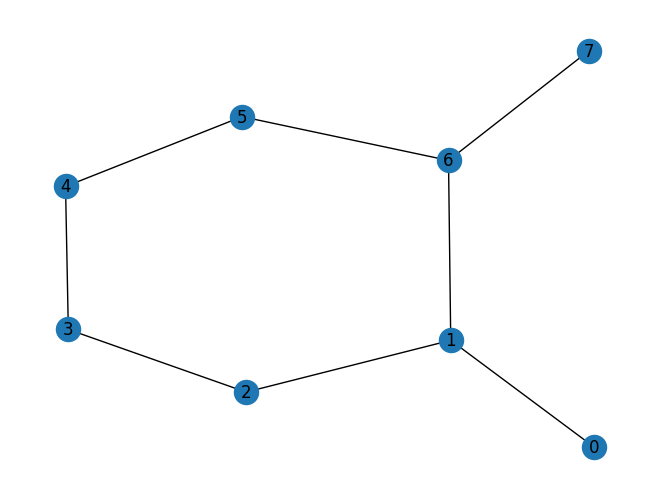

reconstructed molecule: OC1=CC=COC1=N


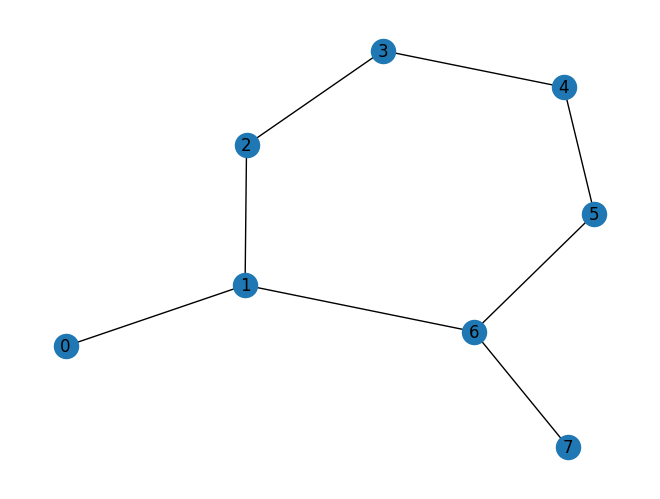

reconstructed molecule: OC1=NC=CNC1O


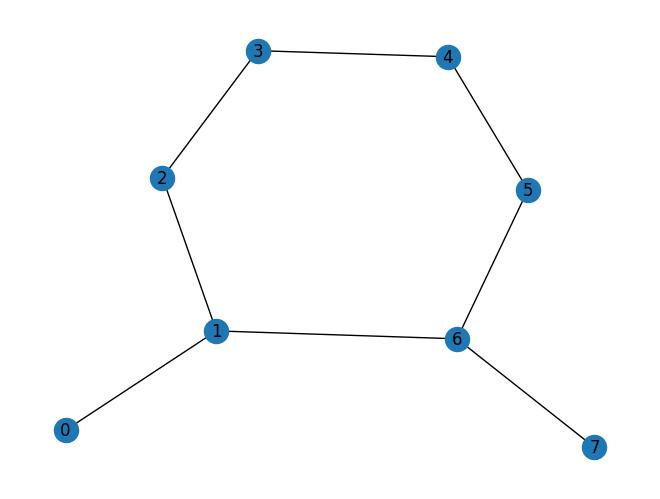

In [12]:
# number of drwas
trial_runs = 5

# Read the SMILES string
mol = read_smiles(selfies.decoder(selfie_input))

# Create a drawing of the molecule
pos = nx.spring_layout(mol)
nx.draw(mol, pos, with_labels=True)

# Display the drawing
print("input molecule",selfies.decoder(selfie_input))
plt.show()
print("")
print("")
print("")

for i in range(trial_runs):
    coded_selfie_from_latent_space = decode_from_latentspace(create_latent_space_vector(selfie_input,largest_selfies_len,selfies_alphabet) , largest_selfies_len, len(selfies_alphabet),1) 
    selfie_from_latent_space = translate_selfie(coded_selfie_from_latent_space)
    #if len(selfies.decoder(selfie_from_latent_space)) > len( selfies.decoder(selfie_input)) - 1 and len(selfies.decoder(selfie_from_latent_space)) < len( selfies.decoder(selfie_input)) + 1:
        # Read the SMILES string
    mol = read_smiles( selfies.decoder(selfie_from_latent_space) )
        # Create a drawing of the molecule
    pos = nx.spring_layout(mol)
    nx.draw(mol, pos, with_labels=True)
        # Display the drawing
    print("reconstructed molecule:",  selfies.decoder(selfie_from_latent_space))
        
    plt.show()